In [119]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import altair as alt
from fuzzywuzzy import process

The data used for this project is taken from the Netflix catalog in May 2022. (Source: https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies). The goal of this project is to use data preprocessing methods and machine learning methods to create a model that recommends users a Netflix title based off similarities in the title's attributes such as run time, genre, age certification ratings, IMDb ratings, release year, etc.

In [120]:
title = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR25YhrFZ9UO62GKEYUrBRP6UM-wo00KZcy15gAvhZZZNhlLTecXkludlC6iNTvAG7cqNcwh65aWIRC/pub?gid=1754548187&single=true&output=csv')

In [121]:
title1=title.copy()

# Initial data study

In [122]:
# Checking data type and info of each column
title.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5806 non-null   object 
 1   title                 5805 non-null   object 
 2   type                  5806 non-null   object 
 3   description           5788 non-null   object 
 4   release_year          5806 non-null   int64  
 5   age_certification     3196 non-null   object 
 6   runtime               5806 non-null   int64  
 7   genres                5806 non-null   object 
 8   production_countries  5806 non-null   object 
 9   seasons               2047 non-null   float64
 10  imdb_id               5362 non-null   object 
 11  imdb_score            5283 non-null   float64
 12  imdb_votes            5267 non-null   float64
 13  tmdb_popularity       5712 non-null   float64
 14  tmdb_score            5488 non-null   float64
dtypes: float64(5), int64(

In [123]:
# Preview of the data
title.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


In [124]:
# Number of rows & columns in data
title.shape

(5806, 15)

In [125]:
# Statistical details
title.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5806.000000,5806.000000,2047.000000,5283.000000,5.267000e+03,5712.000000,5488.000000
mean,2016.013434,77.643989,2.165608,6.533447,2.340719e+04,22.525660,6.818039
std,7.324883,39.474160,2.636207,1.160932,8.713432e+04,68.849177,1.171560
min,1945.000000,0.000000,1.000000,1.500000,5.000000e+00,0.009442,0.500000
25%,2015.000000,44.000000,1.000000,5.800000,5.210000e+02,3.155250,6.100000
50%,2018.000000,84.000000,1.000000,6.600000,2.279000e+03,7.478000,6.900000
75%,2020.000000,105.000000,2.000000,7.400000,1.014400e+04,17.775750,7.500000
max,2022.000000,251.000000,42.000000,9.600000,2.268288e+06,1823.374000,10.000000


In [126]:
# Counting null values
title.isnull().sum()

id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2610
runtime                    0
genres                     0
production_countries       0
seasons                 3759
imdb_id                  444
imdb_score               523
imdb_votes               539
tmdb_popularity           94
tmdb_score               318
dtype: int64

To get a better hold of the null values, let us look into the percentage of missing values in each column

In [127]:
# Which columns contain a lot of null values
Nullpercent = title.isnull().sum().sort_values(ascending = False) / len(title) * 100
null_df = pd.DataFrame({'Features': Nullpercent.index, 'Null_Value_Percentage': Nullpercent.values}).style.background_gradient(cmap='Greens')
null_df

,Features,Null_Value_Percentage
0,seasons,64.743369
1,age_certification,44.953496
2,imdb_votes,9.283500
3,imdb_score,9.007923
4,imdb_id,7.647261
5,tmdb_score,5.477093
6,tmdb_popularity,1.619015
7,description,0.310024
8,title,0.017224
9,id,0.000000


We can notice that the seasons column has a lot missing values, but this is easily explained away since movies are listed missing values for this column. The age certification column also has a lot of missing values later we will encode these values as not rated for the model. For the rest of the columns these missing values are likely due to the title not being on IMDb or tmdb (The Movie Database) and will be filled with zeros for the model.

# Data Exploration and Visualisation

The data is explored seperately for shows and movie types.

## Shows data

In [145]:
# New df= filter: only shows
shows = title1[title1.type == "SHOW"]
shows.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
5,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"['comedy', 'european']",['GB'],4.0,tt0063929,8.8,72895.0,12.919,8.3
29,ts45948,Monty Python's Fliegender Zirkus,SHOW,Monty Python's Fliegender Zirkus consisted of ...,1972,TV-MA,43,['comedy'],[],1.0,tt0202477,8.1,2144.0,1.490,7.0
47,ts20681,Seinfeld,SHOW,A stand-up comedian and his three offbeat frie...,1989,TV-PG,24,['comedy'],['US'],9.0,tt0098904,8.9,302700.0,128.743,8.3
55,ts22082,Knight Rider,SHOW,"Michael Long, an undercover police officer, is...",1982,TV-PG,51,"['action', 'scifi', 'crime', 'drama']",['US'],4.0,tt0083437,6.9,33760.0,44.378,7.5


### Dropping the null values

In [146]:
# Drop nulls on scores & pop
shows_clean = shows.dropna(subset=['imdb_id','imdb_score','imdb_votes','tmdb_popularity','tmdb_score'])
shows_clean.isnull().sum()

id                        0
title                     0
type                      0
description               1
release_year              0
age_certification       188
runtime                   0
genres                    0
production_countries      0
seasons                   0
imdb_id                   0
imdb_score                0
imdb_votes                0
tmdb_popularity           0
tmdb_score                0
dtype: int64

### Correlation using heatmap

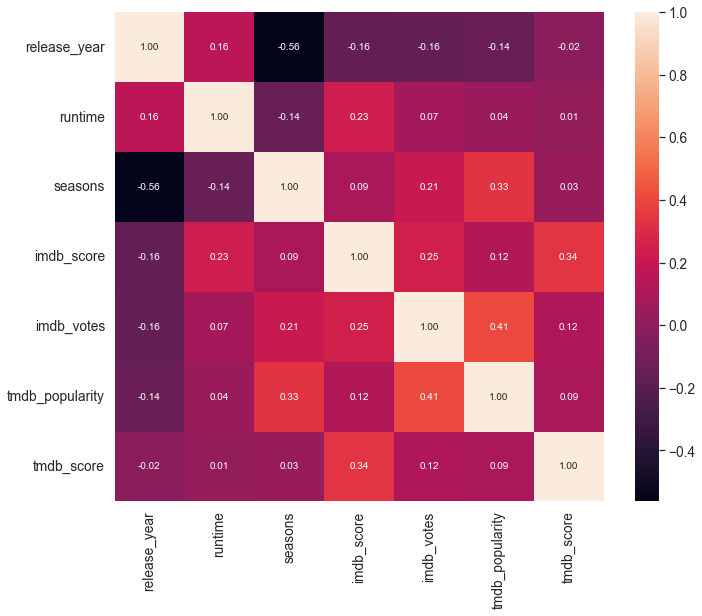

In [147]:
corrmat_shows= shows_clean.corr()

#Set font size
sns.set(font_scale=1.25)

#set graph size
f, ax = plt.subplots(figsize=(11,9))
    # I try to fit the graph in a 100% zoom average monitor. 11 & 9 are usually ok but it depends on the graph and other things. 

#create corr heatmap
hm_shows= sns.heatmap(corrmat_shows,cbar=True, annot=True, square=True, fmt= ".2f", annot_kws={"size":10,},yticklabels= corrmat_shows.index, xticklabels=corrmat_shows.index)
    
#Show heatmap
plt.show()

#OBSERVATIONS: 

1. The 2 different scores: imdb and tmdb have a weak/normal correlation , which is ilogical. A good show should have similar score platform independent. 
2. Number of seasons has a small correlation with tmdb_popularity whichs sounds logical. High Popularity should infer more seasons. But, surprisingly it has almost none with score. This will be analyzed in detail later.
3.Release_year doesnt affect popularity or score. The same goes for "runtime"
4. imdb_votes has correlations with 2 other variables but too small. It is somehow similar to tmdb_popularity.

### Release years of various shows

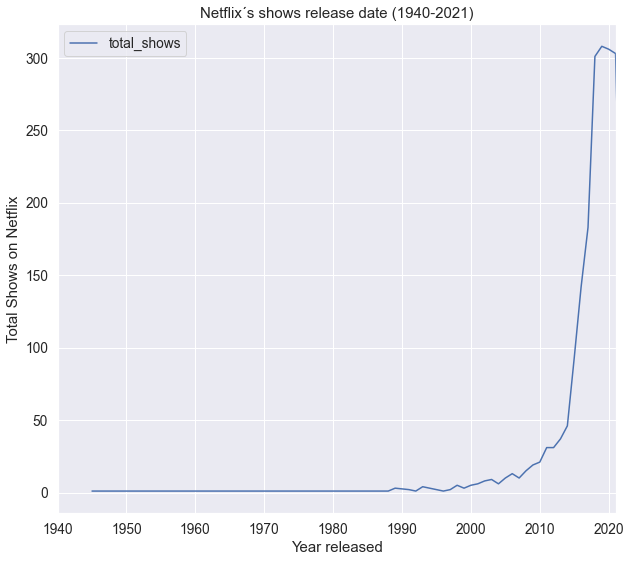

In [148]:
#The following code acts as a groupby + count:
shows_per_year = shows.release_year.value_counts()
#check
#shows_per_year.head()

# transform object into df
shows_per_year = pd.DataFrame(shows_per_year)


# change column titles
shows_per_year.rename(columns = {'release_year':'total_shows'}, inplace = True)

#------------------------------
# line graph

plt.figure(figsize=(10, 9))
sns.lineplot(data= shows_per_year)
plt.title('Netflix´s shows release date (1940-2021)')
plt.xlim(1940, 2021)
plt.xlabel('Year released')
plt.ylabel('Total Shows on Netflix')
plt.show()

 The years in which highest number of shows were released are analysed separately

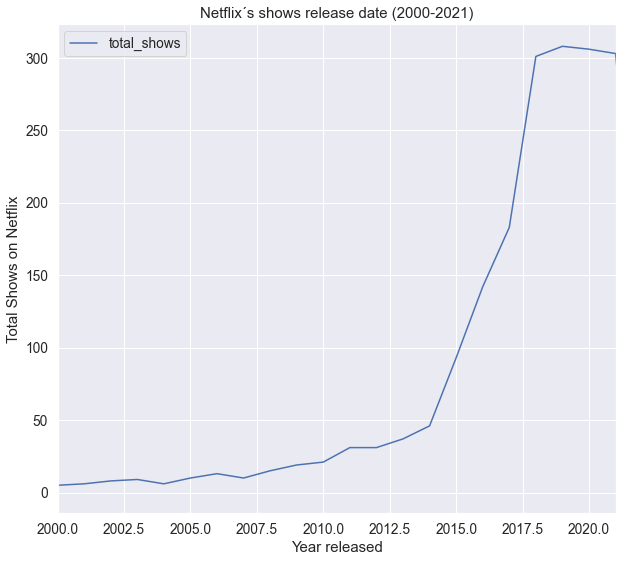

In [149]:
# Between 2000 and 2021
plt.figure(figsize=(10, 9))
sns.lineplot(data= shows_per_year)
plt.title('Netflix´s shows release date (2000-2021)')
plt.xlim(2000, 2021)
plt.xlabel('Year released')
plt.ylabel('Total Shows on Netflix')
plt.show()

Priting the year in which maximum number of shows were released

In [150]:
max_shows = max(shows_per_year.total_shows)

# Year with max value
#Find index with value: 
year_with_max_shows= shows_per_year.index[shows_per_year['total_shows'] == max_shows].tolist()
 

#temporary print
print (f' Most Netflix´s shows were released on: {year_with_max_shows} with a total of {max_shows} shows')

 Most Netflix´s shows were released on: [2019] with a total of 308 shows


### No.of shows per age certification

In [151]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

Text(0.5, 0, 'Age Certification')

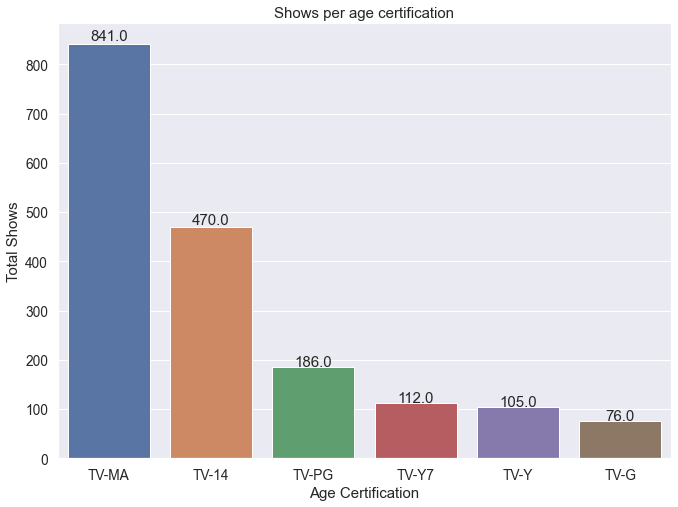

In [152]:
shows_certification = shows.age_certification.value_counts()

# transform object into df
shows_certification = pd.DataFrame(shows_certification)

# change column titles
shows_certification.rename(columns = {'age_certification':'total_shows'}, inplace = True)

#--------------------
#Barchart (seaborn)

# Width and height of the figure
plt.figure(figsize=(11,8))

# Title
plt.title("Shows per age certification")

# Bar chart 
b_shows_certification = sns.barplot(x=shows_certification.index, y=shows_certification["total_shows"], data=shows_certification, ci=None)

#Show values: I use pre-made function (show_values) 
show_values(b_shows_certification)

# Title y-axis
plt.ylabel("Total Shows")
plt.xlabel("Age Certification")

In [153]:
# Printing max category and its value

# Category with max 
max_shows_in_category = max(shows_certification.total_shows)

#Find index with value: 
category_with_max_shows= shows_certification.index[shows_certification['total_shows'] == max_shows_in_category].tolist()

#temporary print
print (f'The category with more shows is: {category_with_max_shows} with a total of {max_shows_in_category} shows')

The category with more shows is: ['TV-MA'] with a total of 841 shows


### Average run time of the shows

In [154]:
# max
b= max(shows.runtime)

# min 
c= min((shows[shows.runtime >0]).runtime)
    

# mean
a= np.mean((shows[shows.runtime >0]).runtime)
    
a= int(a)

#print
print(f'The mean duration for an episode is {a} minutes, the maximum is {b} and minimum is {c}')

The mean duration for an episode is 39 minutes, the maximum is 225 and minimum is 2


### Countries where the shows are made

Text(0.5, 0, 'Production Country')

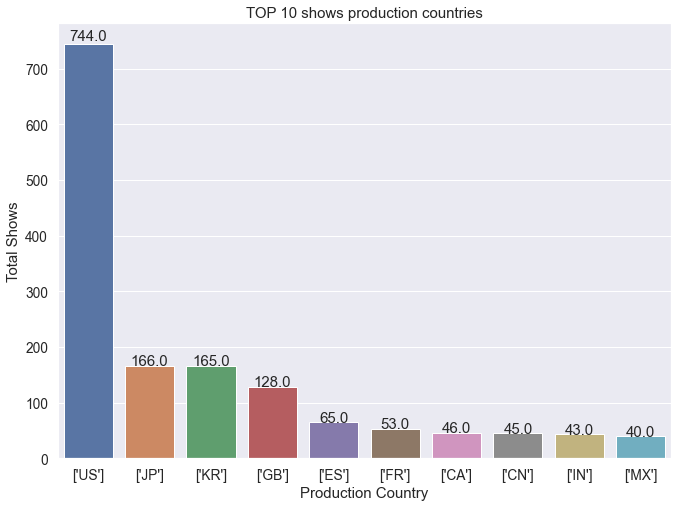

In [155]:
# create object
shows_countries = shows.production_countries.value_counts()

# object to df
shows_countries = pd.DataFrame(shows_countries)

# change column titles
shows_countries.rename(columns = {'production_countries':'total_shows'}, inplace = True)

#Drop index with empty values
shows_countries = shows_countries.drop('[]')

# filter top 10 values. 
top10_countries= shows_countries.head(10)


#--------------------
#Barchart (seaborn)

# Width and height of the figure
plt.figure(figsize=(11,8))

# Title
plt.title("TOP 10 shows production countries")

# Bar chart 
b_top10_countries = sns.barplot(x=top10_countries.index, y=top10_countries["total_shows"], data=top10_countries, ci=None)

#Show values
# I use pre-made function: 
show_values(b_top10_countries)

# Title y-axis
plt.ylabel("Total Shows")
plt.xlabel("Production Country")

In [156]:
# Printing max category and its value

# Category with max 
max_shows_made_in_country = max(shows_countries.total_shows)

#Find index with value: 
Country_with_max_shows = shows_countries.index[shows_countries['total_shows'] == max_shows_made_in_country].tolist()

#temporary print
print (f'The Country with more shows on Netflix is: {Country_with_max_shows} with a total of {max_shows_made_in_country} shows')

The Country with more shows on Netflix is: ["['US']"] with a total of 744 shows


## Movies data

In [157]:
# New df= filter: only shows
movies = title1[title1.type == "MOVIE"]
movies.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7
6,tm14873,Dirty Harry,MOVIE,When a madman dubbed 'Scorpio' terrorizes San ...,1971,R,102,"['thriller', 'crime', 'action']",['US'],NaN,tt0066999,7.7,153463.0,14.745,7.5


### Dropping the null values

In [158]:
# Drop nulls on scores & pop
movies_clean = shows.dropna(subset=['imdb_id','imdb_score','imdb_votes','tmdb_popularity','tmdb_score'])
movies_clean.isnull().sum()

id                        0
title                     0
type                      0
description               1
release_year              0
age_certification       188
runtime                   0
genres                    0
production_countries      0
seasons                   0
imdb_id                   0
imdb_score                0
imdb_votes                0
tmdb_popularity           0
tmdb_score                0
dtype: int64

### Correlation using heatmap

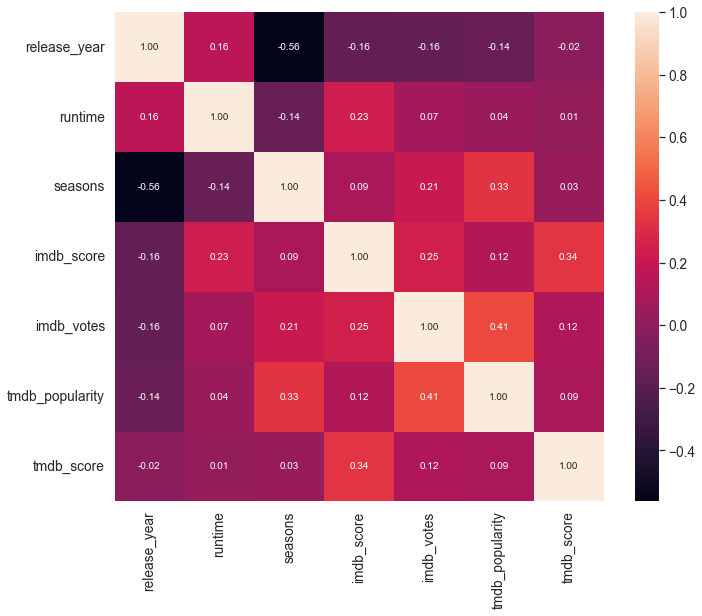

In [159]:
corrmat_movies= movies_clean.corr()

#Set font size
sns.set(font_scale=1.25)

#set graph size
f, ax = plt.subplots(figsize=(11,9))
    # I try to fit the graph in a 100% zoom average monitor. 11 & 9 are usually ok but it depends on the graph and other things. 

#create corr heatmap
hm_movies= sns.heatmap(corrmat_movies,cbar=True, annot=True, square=True, fmt= ".2f", annot_kws={"size":10,},yticklabels= corrmat_movies.index, xticklabels=corrmat_movies.index)
    
#Show heatmap
plt.show()

#OBSERVATIONS: 

1. The 2 different scores: imdb and tmdb have a weak/normal correlation , which is ilogical. A good movie should have similar score platform independent. 
2. Number of seasons has a small correlation with tmdb_popularity whichs sounds logical. High Popularity should infer more seasons. But, surprisingly it has almost none with score. This will be analyzed in detail later.
3. Release_year doesnt affect popularity or score. The same goes for "runtime"
4. imdb_votes has correlations with 2 other variables but too small. It is somehow similar to tmdb_popularity.

### Release years of various movies

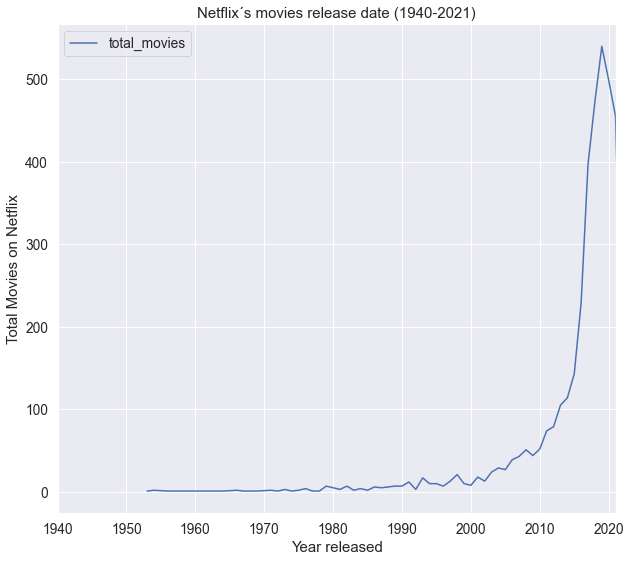

In [160]:
#The following code acts as a groupby + count:
movies_per_year = movies.release_year.value_counts()
#check
#shows_per_year.head()

# transform object into df
movies_per_year = pd.DataFrame(movies_per_year)


# change column titles
movies_per_year.rename(columns = {'release_year':'total_movies'}, inplace = True)

#------------------------------
# line graph

plt.figure(figsize=(10, 9))
sns.lineplot(data= movies_per_year)
plt.title('Netflix´s movies release date (1940-2021)')
plt.xlim(1940, 2021)
plt.xlabel('Year released')
plt.ylabel('Total Movies on Netflix')
plt.show()

 The years in which highest number of shows were released are analysed separately

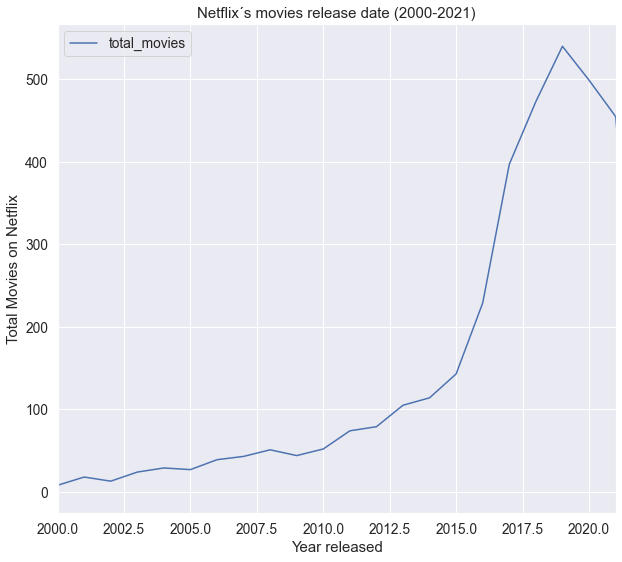

In [161]:
# Between 2000 and 2021
plt.figure(figsize=(10, 9))
sns.lineplot(data= movies_per_year)
plt.title('Netflix´s movies release date (2000-2021)')
plt.xlim(2000, 2021)
plt.xlabel('Year released')
plt.ylabel('Total Movies on Netflix')
plt.show()

Priting the year in which maximum number of shows were released

In [162]:
max_movies = max(movies_per_year.total_movies)

# Year with max value
#Find index with value: 
year_with_max_movies= movies_per_year.index[movies_per_year['total_movies'] == max_movies].tolist()
# This code returns all the indexes with that value, this would be a problem if there were 2 years with identical values. 

#temporary print
print (f' Most Netflix´s movies were released on: {year_with_max_movies} with a total of {max_movies} movies')

 Most Netflix´s movies were released on: [2019] with a total of 540 movies


### No.of movies per age certification

In [163]:
def movie_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

Text(0.5, 0, 'Age Certification')

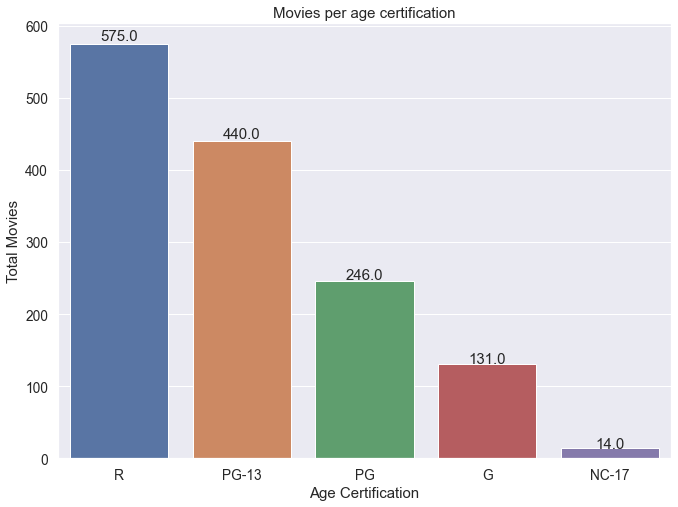

In [164]:
movies_certification = movies.age_certification.value_counts()

# transform object into df
movies_certification = pd.DataFrame(movies_certification)

# change column titles
movies_certification.rename(columns = {'age_certification':'total_movies'}, inplace = True)

#--------------------
#Barchart (seaborn)

# Width and height of the figure
plt.figure(figsize=(11,8))

# Title
plt.title("Movies per age certification")

# Bar chart 
b_movies_certification = sns.barplot(x=movies_certification.index, y=movies_certification["total_movies"], data=movies_certification, ci=None)

#Show values: I use pre-made function (show_values) 
show_values(b_movies_certification)

# Title y-axis
plt.ylabel("Total Movies")
plt.xlabel("Age Certification")

In [165]:
# Printing max category and its value

# Category with max 
max_movies_in_category = max(movies_certification.total_movies)

#Find index with value: 
category_with_max_movies= movies_certification.index[movies_certification['total_movies'] == max_movies_in_category].tolist()

#temporary print
print (f'The category with more movies is: {category_with_max_movies} with a total of {max_movies_in_category} movies')

The category with more movies is: ['R'] with a total of 575 movies


### Average run time of the movies

In [166]:
# max
b= max(movies.runtime)

# min 
c= min((movies[movies.runtime >0]).runtime)

# mean
a= np.mean((movies[movies.runtime >0]).runtime)
     
a= int(a)

#print
print(f'The mean duration for a movie is {a} minutes, the maximum is {b} and minimum is {c}')

The mean duration for a movie is 98 minutes, the maximum is 251 and minimum is 3


### Countries where the shows are made

Text(0.5, 0, 'Production Country')

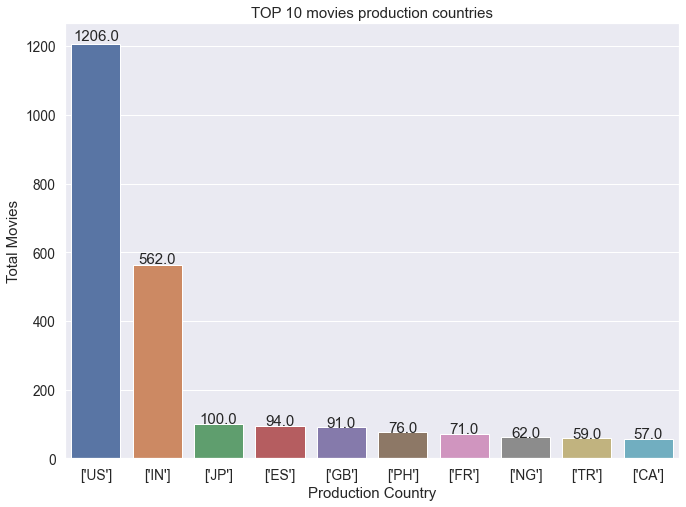

In [167]:
# create object
movies_countries = movies.production_countries.value_counts()

# object to df
movies_countries = pd.DataFrame(movies_countries)

# change column titles
movies_countries.rename(columns = {'production_countries':'total_movies'}, inplace = True)

#Drop index with empty values
movies_countries = movies_countries.drop('[]')

# filter top 10 values. 
top10_countries= movies_countries.head(10)


#--------------------
#Barchart (seaborn)

# Width and height of the figure
plt.figure(figsize=(11,8))

# Title
plt.title("TOP 10 movies production countries")

# Bar chart 
bar_top10_countries = sns.barplot(x=top10_countries.index, y=top10_countries["total_movies"], data=top10_countries, ci=None)

#Show values
# I use pre-made function: 
movie_values(bar_top10_countries)

# Title y-axis
plt.ylabel("Total Movies")
plt.xlabel("Production Country")

In [168]:
# Printing max category and its value

# Category with max 
max_movies_made_in_country = max(movies_countries.total_movies)

#Find index with value: 
Country_with_max_movies = movies_countries.index[movies_countries['total_movies'] == max_movies_made_in_country].tolist()

#temporary print
print (f'The Country with more movies on Netflix is: {Country_with_max_movies} with a total of {max_movies_made_in_country} movies')

The Country with more movies on Netflix is: ["['US']"] with a total of 1206 movies


# Recommendation system 

The raw data can be used with K Nearest Neighbors in order to make predictions. K Nearest Neighbors is a good model for this project since its main assumption is that data points that are close to each other are alike. Which should hold as many of the attributes such as genre, release year, IMDb score, and whether or not it is a movie or tv show should ensure that similar titles are close to one another and allow recommendations to be made by selecting titles closest to that specific title.

## Data cleaning

Here, we have many nulls in different columns, more than 10% of total rows. A common practice is to drop them all. But this is not the case. We would have very few rows remaining.

In the following sections, we will use feature engineering and cleaning methods to prepare a dataset from the raw data which is further used in making a recommender system

### Sorting and cleaning based on unique genres

In this section, we clean the genres column and output all of the unique genres that show up in the genres column. With this we engineer new columns that contain 1 (True) and 0 (False) if that specific genre is listed in the genres column. 

In [ ]:
# Finding all the unique genres
array = title.genres.to_list()

array1 = [s.strip("[]") for s in array]

lst = []
for i in range(len(array1)):
    lst.append(array1[i].split(','))

result = list({x for l in lst for x in l})

result1 = [s.strip("' ") for s in result]

# function to get unique values
def unique(list1):
      
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x),

results = unique(result1)


western
reality
comedy
thriller
war
scifi
animation
horror
european
drama
fantasy
crime
music
sport
action
history
family
documentation
romance


In [ ]:
# Creating indictor columns for each genre
title['horror'] = title['genres'].str.contains('horror').astype('int')
title['history'] = title['genres'].str.contains('history').astype('int')
title['european'] = title['genres'].str.contains('european').astype('int')
title['sport'] = title['genres'].str.contains('sport').astype('int')
title['family'] = title['genres'].str.contains('family').astype('int')
title['reality'] = title['genres'].str.contains('reality').astype('int')
title['drama'] = title['genres'].str.contains('drama').astype('int')
title['animation'] = title['genres'].str.contains('animation').astype('int')
title['comedy'] = title['genres'].str.contains('comedy').astype('int')
title['scifi'] = title['genres'].str.contains('scifi').astype('int')
title['music'] = title['genres'].str.contains('music').astype('int')
title['fantasy'] = title['genres'].str.contains('fantasy').astype('int')
title['western'] = title['genres'].str.contains('western').astype('int')
title['thriller'] = title['genres'].str.contains('thriller').astype('int')
title['documentation'] = title['genres'].str.contains('documentation').astype('int')
title['crime'] = title['genres'].str.contains('crime').astype('int')
title['action'] = title['genres'].str.contains('action').astype('int')
title['war'] = title['genres'].str.contains('war').astype('int')
title['romance'] =title['genres'].str.contains('romance').astype('int')
title.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,...,scifi,music,fantasy,western,thriller,documentation,crime,action,war,romance
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,...,0,0,0,0,0,1,0,0,0,0
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,...,0,0,0,0,0,0,1,0,0,0
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,...,0,0,1,0,0,0,0,0,0,0
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,...,0,0,0,0,0,0,0,0,0,0
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,...,0,0,0,0,0,0,0,0,0,0


### Indicators for the type

Since there are only 2 unique values in 'type' column - show and movie,these two columns with 1 and 0 denoting True and False are created.

In [ ]:
# creating indicator columns for show or movie
title['movie'] = title['type'].str.contains('MOVIE').astype('int')
title['show'] = title['type'].str.contains('SHOW').astype('int')
title = title.drop(columns = 'type')

title.head()

,id,title,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,...,fantasy,western,thriller,documentation,crime,action,war,romance,movie,show
0,ts300399,Five Came Back: The Reference Films,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,...,0,0,0,1,0,0,0,0,0,1
1,tm84618,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,...,0,0,0,0,1,0,0,0,1,0
2,tm127384,Monty Python and the Holy Grail,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,...,1,0,0,0,0,0,0,0,1,0
3,tm70993,Life of Brian,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,...,0,0,0,0,0,0,0,0,1,0
4,tm190788,The Exorcist,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,...,0,0,0,0,0,0,0,0,1,0


In the section below more indicator columns are made for each unique age certification level. Since there were many missing values in the age certification column missing values are denoted with 1 in the not rated indicator column.

### Indicators for age certification

In [ ]:
# creating indicator columns for age certification
unique(title['age_certification'])

title['not_rated'] = title['age_certification'].isna().astype('int')
title['TV-Y'] = title['age_certification'].str.contains('TV-Y', na = False).astype('int')
title['TV-PG'] = title['age_certification'].str.contains('TV-PG', na = False).astype('int')
title['PG'] = title['age_certification'].str.contains('PG', na = False).astype('int')
title['R'] = title['age_certification'].str.contains('R', na = False).astype('int')
title['TV-14'] = title['age_certification'].str.contains('TV-14', na = False).astype('int')
title['PG-13'] = title['age_certification'].str.contains('PG-13', na = False).astype('int')
title['TV-Y7'] = title['age_certification'].str.contains('TV-Y7', na = False).astype('int')
title['NC-17'] = title['age_certification'].str.contains('NC-17', na = False).astype('int')
title['G'] = title['age_certification'].str.contains('G', na = False).astype('int')
title['TV-G'] = title['age_certification'].str.contains('TV-G', na = False).astype('int')
title['TV-MA'] = title['age_certification'].str.contains('TV-MA', na = False).astype('int')
title = title.drop(columns = ['age_certification'])
title.head()

PG
TV-14
NC-17
PG-13
TV-MA
TV-Y7
TV-G
G
R
TV-PG
nan
TV-Y


,id,title,description,release_year,runtime,genres,production_countries,seasons,imdb_id,imdb_score,...,TV-PG,PG,R,TV-14,PG-13,TV-Y7,NC-17,G,TV-G,TV-MA
0,ts300399,Five Came Back: The Reference Films,This collection includes 12 World War II-era p...,1945,48,['documentation'],['US'],1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
1,tm84618,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,...,0,0,1,0,0,0,0,0,0,0
2,tm127384,Monty Python and the Holy Grail,"King Arthur, accompanied by his squire, recrui...",1975,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,...,0,1,0,0,0,0,0,1,0,0
3,tm70993,Life of Brian,"Brian Cohen is an average young Jewish man, bu...",1979,94,['comedy'],['GB'],NaN,tt0079470,8.0,...,0,0,1,0,0,0,0,0,0,0
4,tm190788,The Exorcist,12-year-old Regan MacNeil begins to adapt an e...,1973,133,['horror'],['US'],NaN,tt0070047,8.1,...,0,0,1,0,0,0,0,0,0,0


### Dropping unnecessary columns

In [ ]:
# unneeded columns are dropped
titles_mod1 = title.drop(columns = ['title', 'description', 'genres', 'imdb_id', 'production_countries'])
titles_mod1

,id,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,horror,history,...,TV-PG,PG,R,TV-14,PG-13,TV-Y7,NC-17,G,TV-G,TV-MA
0,ts300399,1945,48,1.0,NaN,NaN,0.600,NaN,0,0,...,0,0,0,0,0,0,0,0,0,1
1,tm84618,1976,113,NaN,8.3,795222.0,27.612,8.2,0,0,...,0,0,1,0,0,0,0,0,0,0
2,tm127384,1975,91,NaN,8.2,530877.0,18.216,7.8,0,0,...,0,1,0,0,0,0,0,1,0,0
3,tm70993,1979,94,NaN,8.0,392419.0,17.505,7.8,0,0,...,0,0,1,0,0,0,0,0,0,0
4,tm190788,1973,133,NaN,8.1,391942.0,95.337,7.7,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5801,tm1014599,2021,100,NaN,6.9,39.0,0.966,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
5802,tm1108171,2021,74,NaN,NaN,NaN,1.036,8.5,0,0,...,0,0,0,0,0,0,0,0,0,0
5803,tm1045018,2021,88,NaN,6.5,32.0,0.709,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
5804,tm1098060,2021,116,NaN,6.2,9.0,2.186,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filling the Nan values

In [ ]:
# Changing NA's to zeros
titles_mod1 = titles_mod1.fillna(0).drop(columns='id')
titles_mod1.head()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,horror,history,european,...,TV-PG,PG,R,TV-14,PG-13,TV-Y7,NC-17,G,TV-G,TV-MA
0,1945,48,1.0,0.0,0.0,0.600,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1976,113,0.0,8.3,795222.0,27.612,8.2,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1975,91,0.0,8.2,530877.0,18.216,7.8,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,1979,94,0.0,8.0,392419.0,17.505,7.8,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1973,133,0.0,8.1,391942.0,95.337,7.7,1,0,0,...,0,0,1,0,0,0,0,0,0,0


## Model for recommender system

### Normalisation for Recommendation system

Here, all the columns are normalized from 0 to 1. This normalization is done to ensure that none of the columns have a greater weight when passed into the K Nearest Neighbor model that will be used for making recommendations.

In [ ]:
# Normalizing data
normalized_data = (titles_mod1 - titles_mod1.min())/(titles_mod1.max() - titles_mod1.min())
normalized_data.head()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,horror,history,european,...,TV-PG,PG,R,TV-14,PG-13,TV-Y7,NC-17,G,TV-G,TV-MA
0,0.000000,0.191235,0.02381,0.000000,0.000000,0.000329,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.402597,0.450199,0.00000,0.864583,0.350582,0.015143,0.82,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.389610,0.362550,0.00000,0.854167,0.234043,0.009990,0.78,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.441558,0.374502,0.00000,0.833333,0.173002,0.009600,0.78,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.363636,0.529880,0.00000,0.843750,0.172792,0.052286,0.77,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Making the model

We fit the K Nearest Neighbors model below and use cosine similarity as the metric to determine how close titles are from each other.

In [ ]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn.fit(normalized_data)

NearestNeighbors(algorithm='brute', metric='cosine')

In the block below we create a function that allows users to type in a movie title and if it is an exact match to one in the dataset then **ten recommendations** with the closest cosine similarity to the model are outputted. 

If the title is not found, a function is used to give close matches to what the user inputted and allows for the user to input in a title again.

In [ ]:
# creating df of title names
title_names = title.loc[ : , ['title']]
title_names['title'] = title_names['title'].str.lower()
title_names.head()

,title
0,five came back: the reference films
1,taxi driver
2,monty python and the holy grail
3,life of brian
4,the exorcist


In [ ]:
#get the ten nearest neighbors
def recomendations(n):
    neighbor_index = knn.kneighbors([normalized_data.loc[n]], return_distance=False, n_neighbors=11)
    neighbor_index = list(neighbor_index[0])
    neighbor_index = neighbor_index[1:11]
    print("Recomendations for: " + title_names.loc[n, 'title'])
    print(title_names.loc[neighbor_index])

In [ ]:
netflix_titles = list(title_names.loc[:, 'title'])

def movie(title):
    title = title.lower()
    result = process.extract(title, netflix_titles, limit = 5)
    i = 1
    for mov in result:
        if (i == 1 and mov[1] <= 80):
            print('No close matches found. Try again.')
            break
        if mov[1] == 100:
            index = netflix_titles.index(title)
            recomendations(index)
            return
        if (mov[1] >= 80 and mov[1] != 100):
            if i == 1:
                print('Exact match not found for {}. Did you mean:'.format(title))
            print(str(i) + ') ' + mov[0])
            i = i+1

## System implementation

In the following blocks some examples are shown using the function to show recommendations.

In [ ]:
movie('breaking bad')

Recomendations for: breaking bad
                 title
1260            narcos
1824             ozark
1835        mindhunter
1826        the sinner
1840             elite
951          wentworth
2198     the mechanism
3362        undercover
4935  the chestnut man
1888       alias grace


c:\Users\Vaishnavi Jayakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [ ]:
movie('Monty Python\'s Flying Circus')

Recomendations for: monty python's flying circus
                          title
367                  still game
257                the it crowd
1292                    flowers
452                  one on one
760                      cuckoo
480                 half & half
1220             schitt's creek
1233           documentary now!
1247          kim's convenience
1934  james acaster: repertoire


c:\Users\Vaishnavi Jayakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [ ]:
movie('walking dead')

Exact match not found for walking dead. Did you mean:
1) the walking dead
2) adú
3) the quick and the dead
4) dead set
5) chhota bheem & krishna: pataliputra- city of the dead


In [ ]:
movie('the walking dead')

Recomendations for: the walking dead
                           title
3241                black summer
4887          all of us are dead
3239                     kingdom
1850              altered carbon
1856  the haunting of hill house
1315                          3%
4909              the silent sea
1305                      glitch
4860                  archive 81
3272   the haunting of bly manor


c:\Users\Vaishnavi Jayakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [ ]:
movie('too hot to handle')

Recomendations for: too hot to handle
                                      title
5796                            the big day
5380              too hot to handle: brazil
5426                  love is blind: brazil
3222                          love is blind
4233  the fabulous lives of bollywood wives
5408                               insiders
4856        the ultimatum: marry or move on
5131                     my unorthodox life
5479                     cooking with paris
3997             million dollar beach house


c:\Users\Vaishnavi Jayakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [ ]:
movie('star wars')
movie('star trek: deep space nine')

Exact match not found for star wars. Did you mean:
1) the little wars
2) star trek: deep space nine
3) look for a star
4) food wars! shokugeki no soma
5) pup star: better 2gether
Recomendations for: star trek: deep space nine
                                title
106                     stargate sg-1
55                       knight rider
306                            merlin
1843                    lost in space
1581   stories by rabindranath tagore
3715              my first first love
2311  final fantasy xiv: dad of light
2302               greenhouse academy
3059                life plan a and b
5176                             eden


c:\Users\Vaishnavi Jayakumar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
